**symptomatic diagnosis in Mental Health**

# Imports Tools

In [ ]:
import pandas as pd
import numpy as np
import re #(removing special characters, numbers, punctuation, etc.) before applying NLP techniques.
import nltk #Natural Language Toolkit — used for text processing (tokenization, stemming, stopword removal).
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import pickle #Used to save (serialize) trained models to disk.
#So you can reuse the model later without retraining.


# Load Dataset

In [ ]:
# Load Dataset
data = pd.read_csv("/content/Diagnosis data.csv", engine='python', on_bad_lines='skip')

# Drop unnecessary column and missing values
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)
data = data.sample(n=6000, random_state=42).reset_index(drop=True)

# Download stopwords
nltk.download('stopwords') #Stopwords  “the”,“is”,carry semantic meaning for classific — removing them reduces noise.
stop_words = set(stopwords.words('english')) # checks fast. If running in an environment that lacks internet or NLTK resources, this may fail — consider packaging stopwords or using built-in stop words

# Text cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    return ' '.join(words)

# Apply cleaning
data['statement'] = data['statement'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
ros = RandomOverSampler(random_state=42) # Create oversampling object
X = data[['statement']]  #Features (X) and Target (y)
y = data['status']
X_res, y_res = ros.fit_resample(X, y)    #balanced feature set.y res balanced labels Balance classes by oversampling minority class
data = pd.concat([X_res, y_res], axis=1) # Merge balanced data back together



this block handles data balancing (fixing class imbalance), a key step before training your ML model.
Creates an instance of the RandomOverSampler from the imblearn (imbalanced-learn) library.

random_state=42 ensures reproducibility — every run gives the same sampling result.

Why:
In many datasets, one class (e.g., “healthy”) may have many more samples than another (e.g., “diagnosed”).
This class imbalance can cause the model to be biased toward the majority class.
The RandomOverSampler fixes this by duplicating samples from the minority class until all classes have equal counts.

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000) #Convert text to numerical feature vectors
X_features = vectorizer.fit_transform(data['statement']) #Generate TF-IDF features for each statement

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(data['status'])  #Encode class labels into numeric form


this part of your code is where text data is transformed into numerical form (so the model can understand it) and labels are encoded into numbers.
Concept	Meaning
Term Frequency (TF)	How often a word appears in a document. (More frequent → higher weight)
Inverse Document Frequency (IDF)	Reduces weight for words common across all documents (e.g., “the”, “is”).
TF-IDF Score	TF × IDF — highlights words that are frequent in one document but rare in others.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2, random_state=42)


In [ ]:
# Individual models
rf = RandomForestClassifier(n_estimators=200, random_state=42)
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier(random_state=42) #Create 3 individual models

# Ensemble using Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('dt', dt)],
    voting='soft'  # Soft voting uses probabilities Use probability-based voting for better accuracy
)

# Train ensemble
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('dt', DecisionTreeClassifier(random_state=42))],
                 voting='soft')

this block of code is where you build, combine, and train your machine learning models.
It uses an ensemble approach (Voting Classifier) to improve prediction accuracy by combining multiple algorithms.
An ensemble combines predictions from multiple models to make a final decision.
Each model independently predicts a class for each sample.

The Voting Classifier combines their outputs to produce the final result.

this below part is all about evaluating your model’s performance after training.
It helps you understand how accurately your Voting Classifier is predicting and where it might be making mistakes.

                      precision    recall  f1-score   support

             Anxiety       0.93      0.99      0.96       342
             Bipolar       0.96      0.99      0.98       397
          Depression       0.72      0.61      0.66       369
              Normal       0.89      0.84      0.86       401
Personality disorder       0.98      1.00      0.99       386
              Stress       0.94      1.00      0.97       361
            Suicidal       0.74      0.77      0.75       396

            accuracy                           0.88      2652
           macro avg       0.88      0.89      0.88      2652
        weighted avg       0.88      0.88      0.88      2652



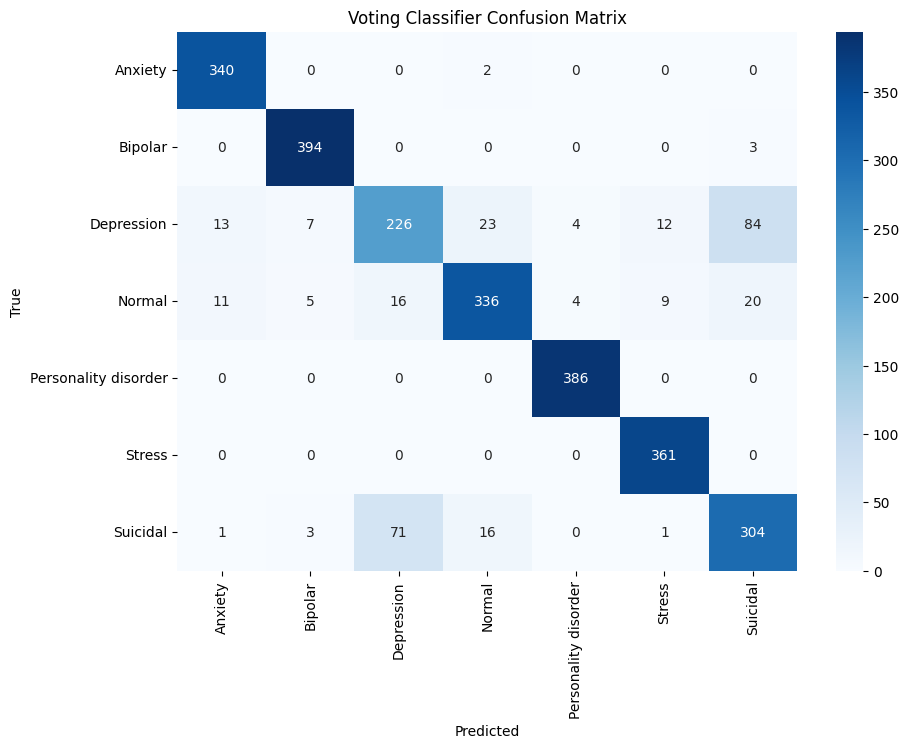

In [ ]:
# Predictions
y_pred = voting_clf.predict(X_test)  #Predict labels for test data

# Classification Report
print(classification_report(y_test, y_pred, target_names=le.classes_)) #Evaluate precision, recall, F1-score

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)  #Compare actual vs predicted classes
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Voting Classifier Confusion Matrix')
plt.show()


The below is  you are saving your trained model and its components so they can be reused later without retraining.

In [ ]:
# Save TF-IDF vectorizer
pickle.dump(vectorizer, open('tfidf_vectorizer.pkl', 'wb'))

# Save Voting Classifier
pickle.dump(voting_clf, open('voting_classifier.pkl', 'wb'))

# Save Label Encoder
pickle.dump(le, open('label_encoder.pkl', 'wb'))


In [ ]:
# Load saved objects
vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
voting_clf = pickle.load(open('voting_classifier.pkl', 'rb'))
le = pickle.load(open('label_encoder.pkl', 'rb'))

# Function to predict mental health status
def predict_status(text):
    cleaned_text = clean_text(text)
    features = vectorizer.transform([cleaned_text])
    pred = voting_clf.predict(features)
    return le.inverse_transform(pred)[0]

# Test with sample text
sample_texts = [
    "I feel anxious and stressed about my work.",
    "I am feeling very happy today.",
    "Sometimes I feel really low and depressed."
]

for text in sample_texts:
    print(f"Text: {text}\nPredicted Status: {predict_status(text)}\n")


Text: I feel anxious and stressed about my work.
Predicted Status: Normal

Text: I am feeling very happy today.
Predicted Status: Normal

Text: Sometimes I feel really low and depressed.
Predicted Status: Depression



In [ ]:
!pip install streamlit pyngrok



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 127.9 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("34XyyEia6xv3kLKS62RXVOHSFTX_4QcLy4nSPx7rhi8NU1FP4")


In [ ]:
%%writefile app.py
import streamlit as st
import pickle
from streamlit_lottie import st_lottie
import requests

# --------------------------
# Load Saved Model Components
# --------------------------
vectorizer = pickle.load(open("tfidf_vectorizer.pkl", "rb"))
voting_clf = pickle.load(open("voting_classifier.pkl", "rb"))
le = pickle.load(open("label_encoder.pkl", "rb"))

# --------------------------
# Function to load Lottie animations safely
# --------------------------
def load_lottie(url):
    try:
        r = requests.get(url)
        if r.status_code == 200:
            return r.json()
    except:
        return None

# --------------------------
# Lottie animations for each mood
# --------------------------
animations = {
    "Normal": "https://lottie.host/8a0d73f4-7e92-4b82-9b9e-7a3c75e44406/hh5MWGXpsR.json",
    "Anxiety": "https://lottie.host/0a9bfa20-1a4b-4b08-84ef-03528ad6e77d/8UO7Urx6bS.json",
    "Depression": "https://lottie.host/e448caf7-1cd3-4d86-8ad6-cea1be3afc04/pb3rxbR3U8.json"
}

# --------------------------
# Streamlit page configuration
# --------------------------
st.set_page_config(page_title="Notes AI", page_icon="💬", layout="centered")
st.title("💬 Notes AI")
st.write("Understand your emotional wellbeing from the text you write.")

# --------------------------
# User input
# --------------------------
user_input = st.text_area(
    "How are you feeling today?",
    placeholder="Example: I feel anxious and stressed about my work...",
    height=150
)

# --------------------------
# Analyze button
# --------------------------
if st.button("Analyze"):
    if user_input.strip():
        with st.spinner("Analyzing your mood..."):
            # Vectorize input and predict
            features = vectorizer.transform([user_input])
            prediction = voting_clf.predict(features)
            status = le.inverse_transform(prediction)[0]

        st.subheader(f"🧠 Diagnosis Prediction: **{status}**")




Writing app.py


In [ ]:
pip install streamlit requests streamlit-lottie


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 18.1 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok

# Close any old tunnels
ngrok.kill()

# Set your authtoken.
# You can get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("34XyyEia6xv3kLKS62RXVOHSFTX_4QcLy4nSPx7rhi8NU1FP4")


# Start a new tunnel for port 8501
public_url = ngrok.connect(8501)
print("🌐 Your public URL:", public_url)

# Run Streamlit app in the background
!streamlit run app.py &

🌐 Your public URL: NgrokTunnel: "https://untortuous-felsic-cletus.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.145.2.14:8501

